In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

#url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
#url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/42831846b6d7e37dd600253a81098f8a_Download_COVID19_20200502.csv"

In [2]:
url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

filename = url_B.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url_B)
    r.encoding = "UTF-8"
    f.write(r.content)

In [3]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

IFR_BR = [[['AL', 1.1], ['BA', 1.1], ['CE', 1.1], ['MA', 1], ['PB', 1.2], ['PE', 1.1], ['PI', 0], ['RN', 1.1], ['SE', 0]],
          [["AC", 0], ["AM", 0.8], ["AP", 0], ["PA", 0.9], ["RO", 0], ["RR", 0], ["TO", 0]],
          [['ES', 0.9], ['MG', 1], ['RJ', 0.8], ['SP', 0.7]],
          [['PR', 0], ['RS', 0.9], ['SC', 0.8]],
          [['DF', 0], ['GO', 0], ['MT', 0], ['MS', 0]]
         ]

In [4]:
df = pd.read_csv(filename, sep = ",")

df1 = df.drop(['epidemiological_week', 'is_repeated'], axis = 1).sort_values('date', ascending = True)
df1.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate', 'order_for_place' : 'day', 'last_available_date' : 'day_count'}, inplace = True)

In [5]:
for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df1.loc[df1['state'].eq(Regiao[r][a]), 'region'] = reg[r]
        df1.loc[df1['state'].eq(IFR_BR[r][a][0]), 'IFR'] = IFR_BR[r][a][1]

In [14]:
df1

,city,city_ibge_code,date,population,is_last,confirmed,incidence,last_available_date,death_rate,deaths,day,place_type,state,new_confirmed,new_deaths,region,IFR
0,São Paulo,3550308.0,2020-02-25,12252023.0,False,1,0.00816,0,0.0000,0,1,city,SP,1,0,Sudeste,0.7
1,NaN,35.0,2020-02-25,45919049.0,False,1,0.00218,0,0.0000,0,1,state,SP,1,0,Sudeste,0.7
2,São Paulo,3550308.0,2020-02-26,12252023.0,False,1,0.00816,1,0.0000,0,2,city,SP,0,0,Sudeste,0.7
3,NaN,35.0,2020-02-26,45919049.0,False,1,0.00218,1,0.0000,0,2,state,SP,0,0,Sudeste,0.7
4,São Paulo,3550308.0,2020-02-27,12252023.0,False,1,0.00816,2,0.0000,0,3,city,SP,0,0,Sudeste,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296765,Nepomuceno,3144607.0,2020-07-02,26769.0,True,38,141.95525,128,0.0000,0,43,city,MG,0,0,Sudeste,1.0
296764,Nazareno,3144508.0,2020-07-02,8608.0,True,4,46.46840,128,0.0000,0,76,city,MG,0,0,Sudeste,1.0
296763,Natércia,3144409.0,2020-07-02,4730.0,True,1,21.14165,128,0.0000,0,13,city,MG,0,0,Sudeste,1.0
296781,Oliveira,3145604.0,2020-07-02,41687.0,True,26,62.36956,128,0.0000,0,50,city,MG,1,0,Sudeste,1.0


In [6]:
FMT = '%Y-%m-%d'

date = df1['date']
regi = df1['region']

df1['day_count'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [25]:
df_Brasil = df1.loc[df1['city'].isnull(), :].drop(['place_type', 'city_ibge_code', 'population', 'day', 
                                                  'incidence', 'death_rate', 'IFR', 'is_last', 'date'
                                                 ], axis = 1).groupby('day_count').sum()

df_pop = df1.loc[df1['city'].isnull() & (df1['is_last']), ['population', 'state']].reset_index(drop = True)

In [26]:
df_Brasil
#df_pop

,confirmed,deaths,new_confirmed,new_deaths
day_count,,,,
0,1,0,1,0
1,1,0,0,0
2,1,0,0,0
3,2,0,1,0
4,2,0,0,0
...,...,...,...,...
124,1351401,57742,32850,583
125,1372983,58473,21582,731
126,1412664,59791,39681,1318


In [ ]:
df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

In [39]:
pBrasil = df_pop['population'].sum()

# total of days since 2020-01-30 - x
days = list(df_Brasil.index)
x = days

In [40]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    a = np.exp(X[2] * (((np.log(R[2])) / X[2]) - ((np.log(R[1]) - np.log(R[0])) / (X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1]) / X[1])) / ((X[0])**(-1) - (X[1]) ** (-1)))
    return [a, b]

def exp_est (R, X) :
    np.random.seed(max(x))
    a = np.exp(X[2] * (((np.log(R[2])) / X[2]) - ((np.log(R[1]) - np.log(R[0])) / (X[1] - X[0]))))
    b = (np.log(R[2]) / X[2]) - (1 / X[2]) * (((np.log(R[0]) / X[0]) - (np.log(R[1]) / X[1])) / ((X[0]) ** (-1) - (X[1]) ** (-1)))
    return a * np.exp(b * (max(x) + 1)) + norm.rvs(size = 1, scale = 0.05 * (max(x) + 1))

In [44]:
desc = ["Total cases", "Total deaths", "New Cases", "New deaths"]

for i in range(4) :
    y = list(df_Brasil.iloc[:, i])
    d0 = int(3 * max(days) / 4)
    d1 = int(5 * max(days) / 6)
    
    exp_p = exp_param([y[d0], y[d1], y[-1]], [x[d0], x[d1], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1])
    
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in range(3)]
    print(desc[i] + " parameters are: \n")
    for j in range(3) :
        print(str(round(exponential_fit[0][j], 3)) + " +/- " + str(round(exponential_errors[j], 3)))
    print(" \n")

Total cases parameters are: 

7167.208 +/- 6138348248.251
0.039 +/- 0.001
-11.924 +/- 22066264.99
 

Total deaths parameters are: 

1444.908 +/- 276432121.76
0.032 +/- 0.001
7.359 +/- 5931152.13
 

New Cases parameters are: 

10.626 +/- 36821238.755
0.028 +/- 0.002
-168.812 +/- 123033452.479
 

New deaths parameters are: 

0.189 +/- 1496514.554
0.019 +/- 0.002
-331.872 +/- 408167872.244
 



E:\Users\Charles\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [43]:
int(3 * max(days) / 4)

96

## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [45]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

In [63]:
print("The errors of the logistic model parameters of: \n")

a0 = 1.2

lb = [max(days) + 14, max(days) + 14, max(days) + 14, max(days) + 31]


lc = [0.5 * pBrasil, 0.025 * pBrasil, 0.05 * pBrasil, 0.08 * pBrasil]

for i in range(4) :
    x = days
    y = list(df_Brasil.iloc[:, i])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[i], lc[i]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
    
    logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]
   
    print(desc[i] + " numbers are: " + str(logistic_errors) + "\n")

The errors of the logistic model parameters of: 

Confirmed COVID19 cases numbers are: [0.19033097104807103, 0.6179106226306426, 37986.501685416304]

Deaths by COVID19 numbers are: [0.19876159513513628, 0.4292570918621578, 771.1104794796333]

New confirmed COVID19 cases numbers are: [2.0907360949179465, 4.051447062522424, 3914.396830768231]

New confirmed deaths numbers are: [1.2978788654860487, 1.5552185826845328, 33.44241994549632]




# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 243 +/- 0.62 days, with 2149081.356 +/- 37986.5 Confirmed COVID19 cases
Next estimated Confirmed COVID19 cases number is 1692229.391


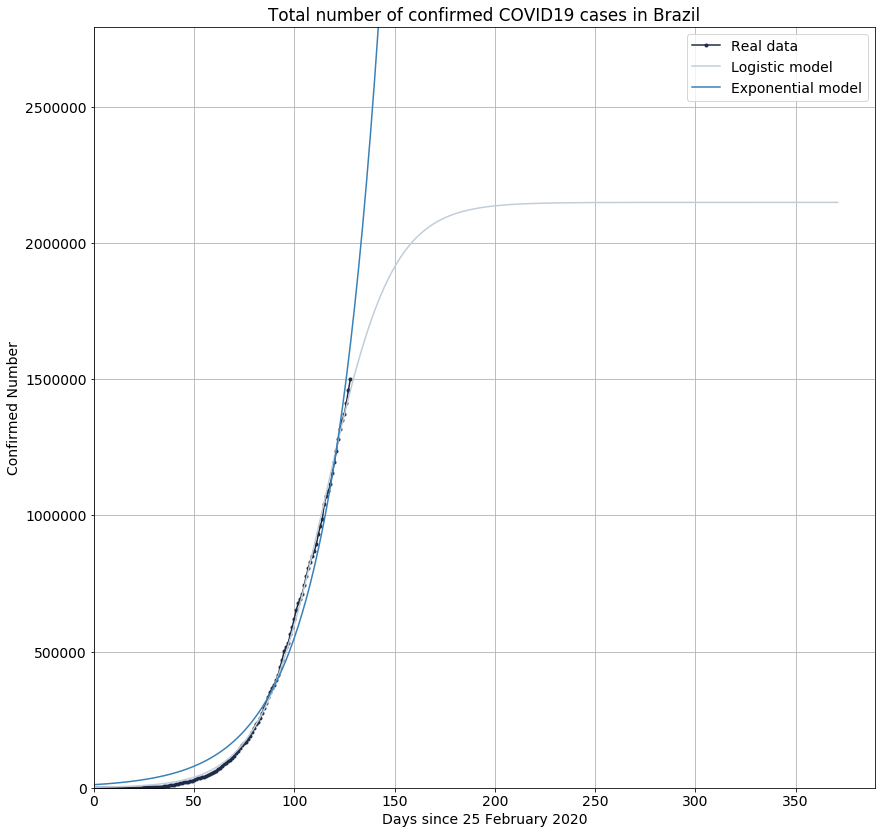

E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 147 +/- 0.43 days, with 70861.953 +/- 771.11 Deaths by COVID19
Next estimated Deaths by COVID19 number is 73089.036


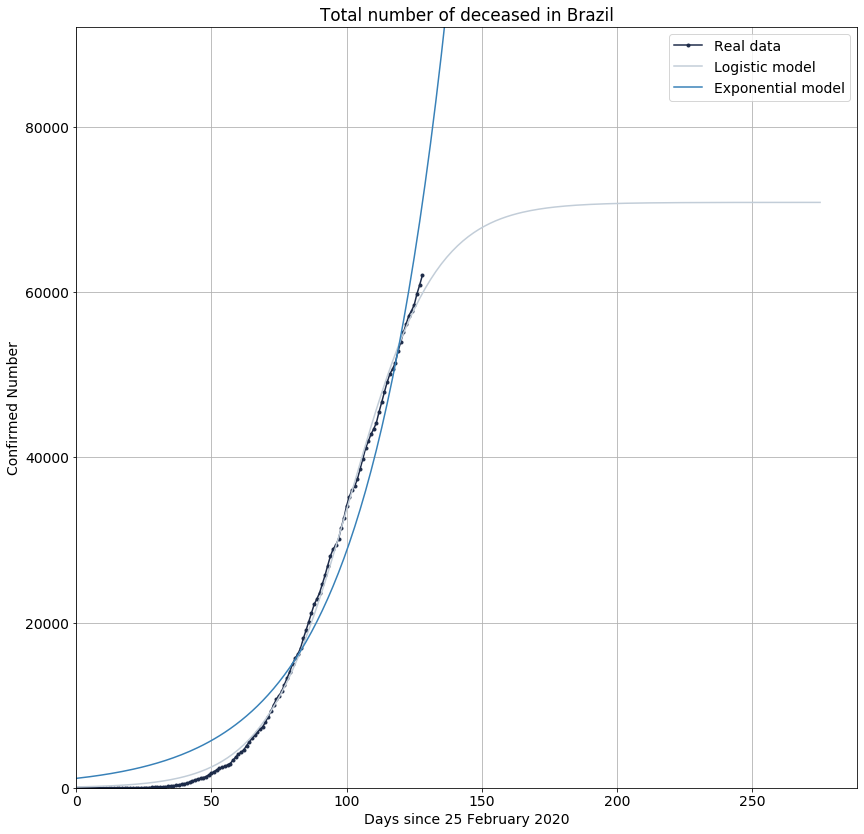

E:\Users\Charles\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
E:\Users\Charles\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


The expected final values: end of spread in 144 +/- 4.05 days, with 42588.889 +/- 3914.4 New confirmed COVID19 cases
Next estimated New confirmed COVID19 cases number is 46668.525


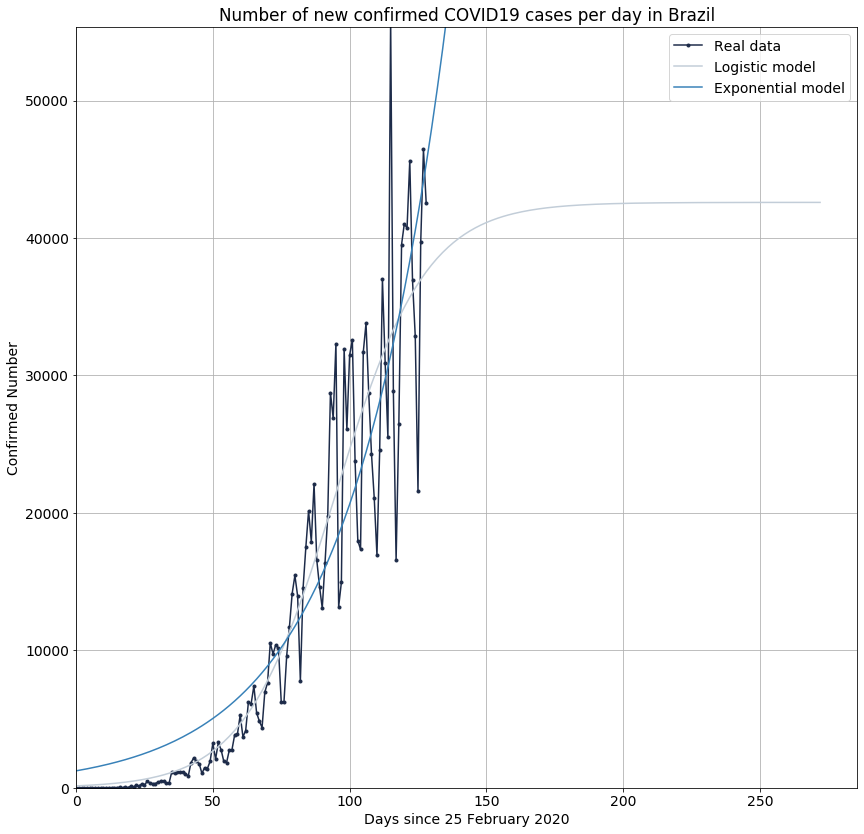

E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 66 +/- 1.56 days, with 1037.003 +/- 33.44 New confirmed deaths
Next estimated New confirmed deaths number is 1400.407


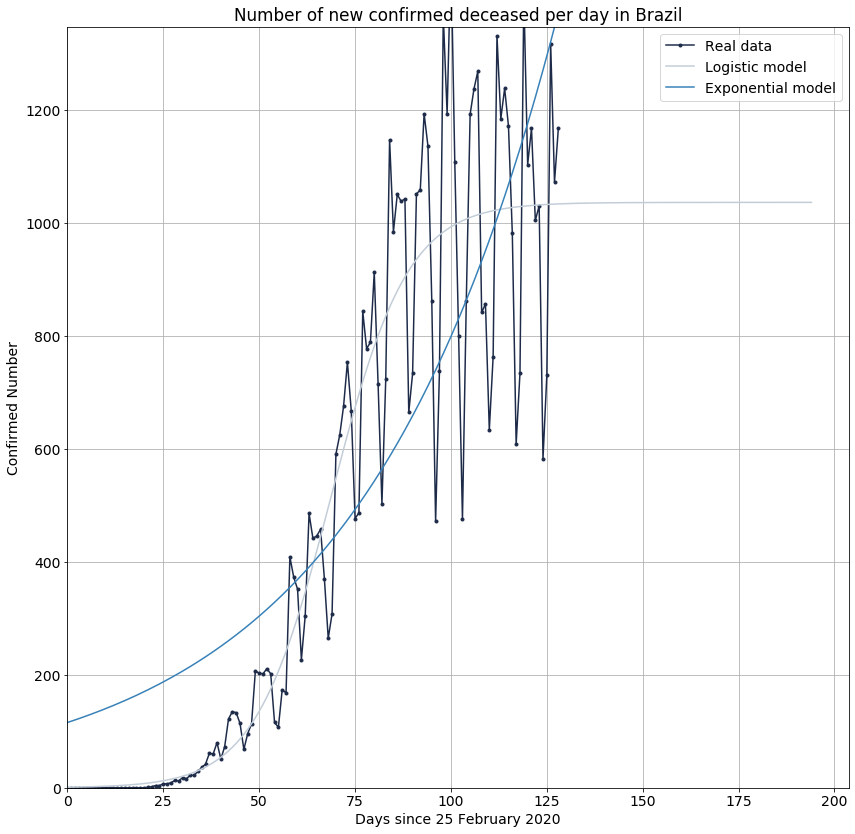

In [64]:
ttl = ["Total number of confirmed COVID19 cases",
        "Total number of deceased",
        "Number of new confirmed COVID19 cases per day",
        "Number of new confirmed deceased per day"]
desc = ["Confirmed COVID19 cases",
        "Deaths by COVID19",
        "New confirmed COVID19 cases",
        "New confirmed deaths"]
expo = []

for f in range(4) :
    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 14]
    x = days
    plt.grid(True)
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 7]
    
    y = list(df_Brasil.iloc[:, f])
      
    exp_p = exp_param([y[d0], y[d1], y[-1]], [x[d0], x[d1], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] * np.exp(-1), exp_p[1], 1])
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                              exponential_fit[0][2]) - int(exponential_fit[0][2]),
                                 exponential_fit[0][1]))
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in [0, 1, 2]]
    
    pred_x = list(range(max(x), max(x) + 15 ))

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")
    
    # Predicted logistic curve for the total data
    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[int(f)], lc[int(f)]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], 
                                                        logistic_fit[0][1], logistic_fit[0][2])
                              - int(logistic_fit[0][2]), logistic_fit[0][1]))

    logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]

    pred_x = list(range(max(x), logistic_sol))

    plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                          for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
    
    print("The expected final values: end of spread in " + str(max(pred_x) - max(x))
          + " +/- " + str(round(logistic_errors[1], 2)) + " days, with " + str(round(logistic_fit[0][2], 3))
          + " +/- " + str(round(logistic_errors[2], 2)) + " " + desc[f])
        
    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")
    
    expo.append(exponential_fit)

    plt.title(ttl[f] + " in Brazil")
    plt.legend()
    plt.xlabel("Days since 25 February 2020")
    plt.ylabel("Confirmed Number")
    
    plt.xlim(0, max(pred_x) * 1.05)
    plt.ylim(0, logistic_fit[0][2] * 1.3)
        
    print("Next estimated " + desc[f] + " number is " + 
          str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)))
    plt.show()

In [65]:
df_Brasil

,confirmed,deaths,new_confirmed,new_deaths
day_count,,,,
0,1,0,1,0
1,1,0,0,0
2,1,0,0,0
3,2,0,1,0
4,2,0,0,0
...,...,...,...,...
124,1351401,57742,32850,583
125,1372983,58473,21582,731
126,1412664,59791,39681,1318


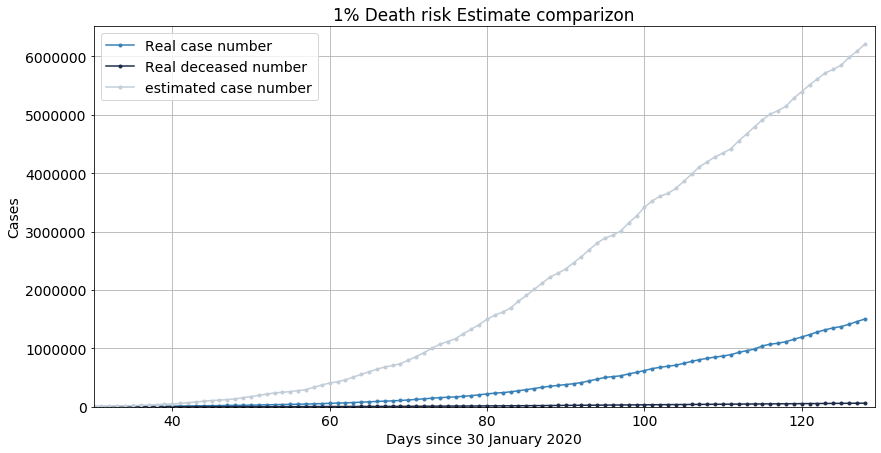

Expected actual value is: 6203200 in day 128


In [67]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df_Brasil.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df_Brasil.iloc[:, 1])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df_Brasil.iloc[:, 1].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk Estimate comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.xlim(30, max(x) * 1.01)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Expected actual value is: " + str(max(y)) + " in day " + str(max(x)))

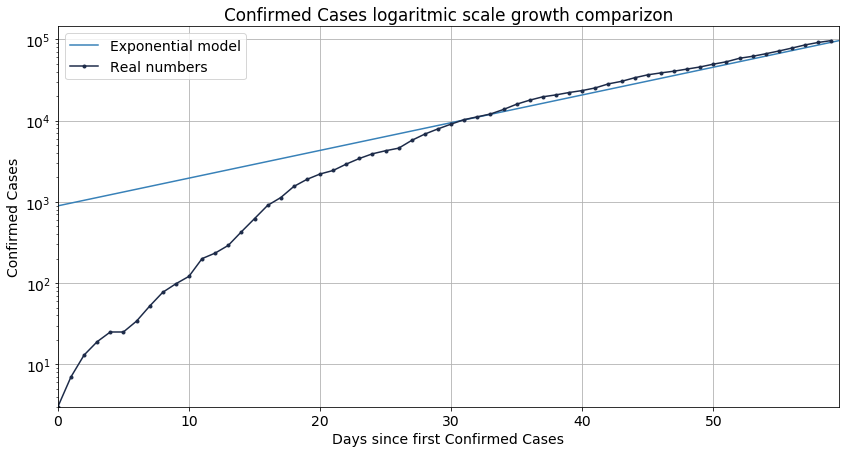

The growth rate of Confirmed Cases is: doubling every 9 days


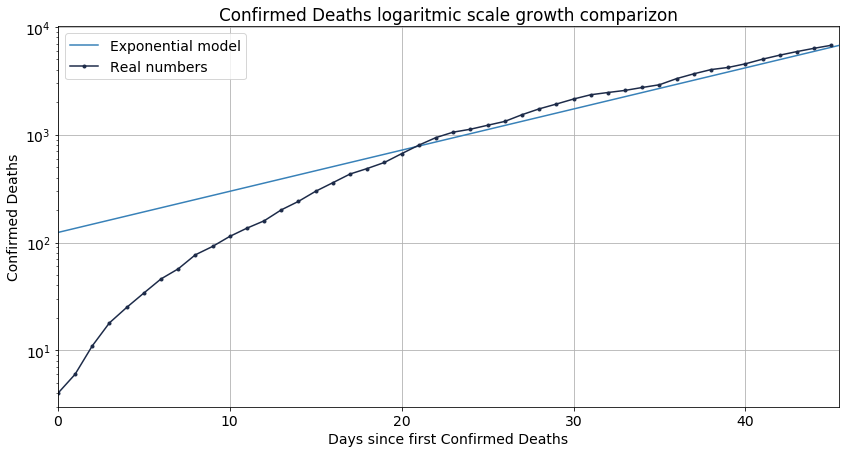

The growth rate of Confirmed Deaths is: doubling every 8 days


In [12]:
inicio = [33, 47]
ttl = ["Confirmed Cases", "Confirmed Deaths"]
for f in range(2) :
    plt.grid(True)
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 7]

    # Lines
    x = days
    y = list(df1.iloc[:, 2 * f])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[f], lc[f]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]),
                              logistic_fit[0][1]))

    exp_p = exp_param([y[-4], y[-2], y[-1]], [x[-4], x[-2], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] - 1, exp_p[1], 1])

    pred_x = list(range(max(x), logistic_sol))

    plt.plot(x + pred_x, [exponential_model(i + inicio[f], exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                              for i in x + pred_x], label = "Exponential model", color = "#3881b8")

    # Real data

    x = list(df1.head(max(days) - inicio[f]).index)

    y = list(df1.iloc[:, 2 * f].tail(max(days) - inicio[f]))
    plt.plot(x, y, marker = '.', label = "Real numbers", color = "#1d2b49")

    plt.title(ttl[f] + " logaritmic scale growth comparizon")
    plt.legend()
    plt.yscale('log')
    plt.xlabel("Days since first " + ttl[f])
    plt.ylabel(ttl[f])
    plt.xlim(0, max(x) * 1.01)
    plt.ylim(3, max(y) * 1.5)
    plt.show()

    print("The growth rate of " + ttl[f] + " is: doubling every " + str(int(round(np.log(2) / exponential_fit[0][1], 0))) + " days")